In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image, ImageDraw
import cv2
import numpy as np
import colorsys
import random

from model.build_model import CascadeRCNN

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
interpolate = torch.nn.functional.interpolate

In [3]:
def get_n_hls_colors(num):
    hls_colors = []
    i = 0
    step = 360.0 / num
    while i < 360:
        h = i
        s = 90 + random.random() * 10
        l = 50 + random.random() * 10
        _hlsc = [h / 360.0, l / 100.0, s / 100.0]
        hls_colors.append(_hlsc)
        i += step
 
    return hls_colors
 
def ncolors(num):
    rgb_colors = []
    if num < 1:
        return rgb_colors
    hls_colors = get_n_hls_colors(num)
    for hlsc in hls_colors:
        _r, _g, _b = colorsys.hls_to_rgb(hlsc[0], hlsc[1], hlsc[2])
        r, g, b = [int(x * 255.0) for x in (_r, _g, _b)]
        rgb_colors.append([r, g, b])
 
    return rgb_colors

In [4]:
def val_aug(SIZE):
    aug = A.Compose([
        A.Resize(height=SIZE[0], width=SIZE[1], p=1.),
        A.Normalize(),
        ToTensorV2()
    ])
    return aug

In [5]:
ckp = torch.load('./best-checkpoint.bin')

cfg = ckp['hyp']
model = CascadeRCNN(cfg).cuda()
model.load_state_dict(ckp['model_state_dict'])
model = model.eval()

In [6]:
img_name = 'imgs/SVB_1942.jpg'
raw_img = Image.open(img_name)
np_img = np.array(raw_img)

proc_img = val_aug((800, 1280))(**{'image': np_img})['image']
proc_img.shape

torch.Size([3, 800, 1280])

In [7]:
with torch.no_grad():
    result = model([{'image': proc_img}])[0]

/home/yons/gk/simple-cascade-d2/utils.py:73: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:945.)
  return x.nonzero().unbind(1)


In [8]:
draw_img = raw_img.resize((1280, 800)).copy()
drawer = ImageDraw.Draw(draw_img)

# for box in result.pred_boxes.tensor:
#     drawer.rectangle(xy=box.cpu().tolist(), outline='red')
    
# draw_img

In [14]:
H, W = draw_img.height, draw_img.width
masks = result.pred_masks
colors = ncolors(len(result.pred_boxes.tensor))
random.shuffle(colors)

mask_img = np.array(draw_img.copy())[..., ::-1]

for i in range(len(result.pred_boxes.tensor)):
    mask = masks[i].cpu()
    box = result.pred_boxes.tensor[i].cpu().long()
    w, h = (box[2] - box[0]).item(), (box[3] - box[1]).item()
    
    up_mask = interpolate(mask[None, ...], size=(h, w), mode='bilinear').squeeze()
    up_mask = up_mask.gt(0.5).numpy().astype(np.uint8)
    
    area = h * w
    if area - up_mask.sum() <= 0.05*area:
        continue
    
    bg = np.zeros((H, W, 3)).astype(np.uint8)
    rgb_mask = up_mask[..., None].repeat(3, axis=2)
    rgb_mask[up_mask == 1, ...] = colors[i]
    
    bg[box[1]:box[3], box[0]:box[2]] = rgb_mask
    
    mask_img = 0.5*bg + mask_img

/home/yons/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3032: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


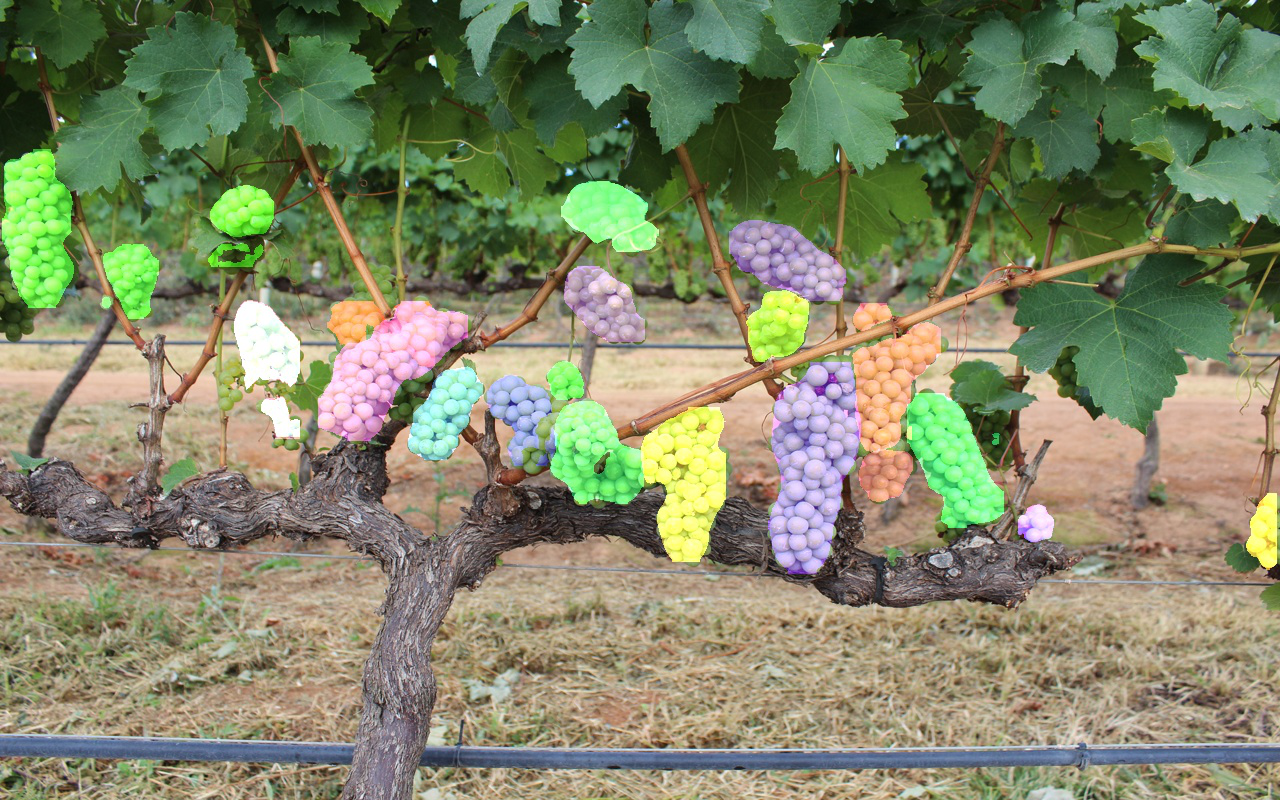

In [15]:
cv2.imwrite('demo.jpg', mask_img)
Image.open('demo.jpg')

In [89]:
!rm demo.jpg